In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from gtime.forecasting.arima import ARIMA
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import TimeSeriesForecastingModel
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv')
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df = time_series_preparation.transform(df_close)

In [3]:
df_train = df.iloc[300:800]
df_test = df.iloc[800:900]

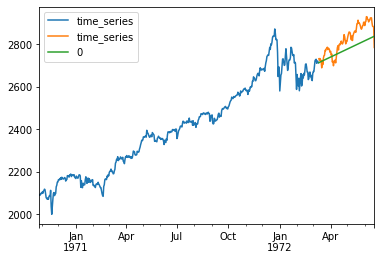

In [4]:
m2 = ARIMA_sm(df_train, (1, 1, 0))
f = m2.fit(method='css')
y2, _, _ = f.forecast(100)
ax = df_train.plot()
df_test.plot(ax=ax)
pred = pd.DataFrame(y2, index=df_test.index)
pred.plot(ax=ax);

In [5]:
features = [
    ("s1", Shift(0), make_column_selector()),
]
model = TimeSeriesForecastingModel(features=features, horizon=100, model=ARIMA((1, 1, 0), method='css'))


model.fit(df.iloc[300:900], None)

TimeSeriesForecastingModel(cache_features=False,
                           features=[('s1', Shift(shift=0),
                                      <sklearn.compose._column_transformer.make_column_selector object at 0x124d3add8>)],
                           horizon=100,
                           model=ARIMA(method='css', order=(1, 1, 0)))

In [6]:
pred_g = model.predict(df_test.iloc[[0]])

Time: 0.01 s
2127.4257051024306
1.283678465224253 [0.04227097] []


In [7]:
y_g = pd.DataFrame(pred_g.T.values, index=pred.index)

In [8]:
np.dot(df.values.flatten()[3:3], df.values.flatten()[3:3])

0.0

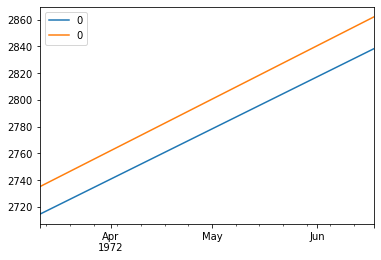

In [9]:
ax = pred.plot()
y_g.plot(ax=ax);

In [10]:
mean_squared_error(y_g, df_test)

1968.4894525613888

In [11]:
mean_squared_error(pred, df_test)

3557.4737010905956

In [12]:
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.time_series   No. Observations:                  499
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2123.083
Method:                           css   S.D. of innovations             17.189
Date:                Mon, 13 Apr 2020   AIC                           4252.167
Time:                        23:24:29   BIC                           4264.799
Sample:                    10-30-1970   HQIC                          4257.124
                         - 03-10-1972                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2513      0.740      1.691      0.091      -0.199       2.701
ar.L1.D.time_series    -0.0412      0.045     -0.921      0.358      -0.129       0.047
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -24.2580           +0.0000j           24.2580            0.5000
-----------------------------------------------------------------------------
"""

In [13]:
model.model.params

,mu,phi,theta
1972-03-11,1.283678,[0.042270966716643966],[]
